# COMP 551 — Assignment 4

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [42]:
pip install unidecode gensim tqdm boto3 requests regex sentencepiece sacremoses transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install numpy==1.23.5

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
radvel 1.4.11 requires numpy==1.24.3, but you have numpy 1.23.5 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/14.6 MB 11.2 MB/s eta 0:00:02
   ------------ --------------------------- 4.5/14.6 MB 12.8 MB/s eta 0:00:01
   ---------------------- ----------------- 8.1/14.6 MB 14.0 MB/s eta 0:00:01
   -------------------------------- ------- 12.1/14.6 MB 15.1 MB/s eta 0:00:01
   ---------------------------------------- 14.6/14.6 MB 14.6 MB/s  0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

from gensim.models import Word2Vec

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer, BertForSequenceClassification

import unidecode
import string

import os
import multiprocessing
import logging # for logging training process
import time # to track training time
import pickle # to save models
import unicodedata

## Defaults Parameters/Settings

In [ ]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.autolimit_mode'] = 'data'  # default, ensures autoscale uses data
plt.rcParams["font.family"] = "serif"


# set default save directory and parameters
SAVEDIR = './figures/'
MODELDIR = './models/'
os.makedirs(SAVEDIR, exist_ok=True)
os.makedirs(MODELDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# set log level
log = logging.getLogger()
log.setLevel(logging.INFO)  # set to logging.DEBUG for more detailed output
for handler in log.handlers[:]: # Remove existing handlers (important in Jupyter)
    log.removeHandler(handler)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter(
    fmt='%(asctime)s - %(message)s', 
    datefmt="%H:%M:%S" 
    )
handler.setFormatter(formatter)
log.addHandler(handler)

# Dataset

## Get data

X is input data that include text sequences

Y is target value 

YL1 is target value of level one (parent label)

YL2 is target value of level one (child label)

In [ ]:
def load_data(file_path, dtype=str)->np.ndarray:
    # read file 
    with open(file_path, "r") as f:
        lines = [line.strip() for line in f]  # list of all lines

    if dtype == int:
        return [int(x) for x in lines]  # make sure target lists are int type
    
    return np.array(lines)  # return array


def clean_text(text):
    """
    Clean text by:
    - lowercasing
    - removing accents
    - removing punctuation
    - keeping only alphanumeric characters, hyphens and spaces
    - removing double spaces
    """
    # Lowercase
    text = text.lower()

    # Removing accents
    text = unicodedata.normalize("NFKD", text)
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")

    punctuation = ",.;:!?\"'()[]{}<>@#$%^&*_+=/\\|`~•–—"  # list of punctuation to remove
    for p in punctuation:
        text = text.replace(p, " ")

    # Keeping only alphanumeric characters, hyphens and spaces
    cleaned = []
    for ch in text:
        if ch.isalnum() or ch == '-' or ch == ' ':
            cleaned.append(ch)
        else:
            cleaned.append(" ")
    text = "".join(cleaned)

    # Removing double spaces
    while "  " in text:
        text = text.replace("  ", " ")
    
    return text.strip()


class WOSDataset(Dataset):
    """
    Class to build a torch dataset from the WOS .txt files
    """

    def __init__(self, dataset_dir, num_children=5):
        self.Xraw = load_data(os.path.join(dataset_dir, 'X.txt')) # not tensor because string elements! oh well :(
        self.X = self.Xraw.copy()
        self.label = 'yl1' # default label
        self.Y =  torch.LongTensor(load_data(os.path.join(dataset_dir, 'Y.txt'), dtype=int)) # using LongTensor for cross-entropy loss (required!)
        self.YL1 = torch.LongTensor(load_data(os.path.join(dataset_dir, 'YL1.txt'), dtype=int))
        self.YL2 = torch.LongTensor(load_data(os.path.join(dataset_dir, 'YL2.txt'), dtype=int))
        self.sentences = []
        self.embedded_sentences = None

        # Compute flattened labels
        self.num_children = num_children
        self.YL_flat =  torch.LongTensor(np.array([yl1 * num_children + yl2 for yl1, yl2 in zip(self.YL1, self.YL2)]))
        
    def set_label(self, label):
        label = label.lower() if isinstance(label, str) else label
        if label in ['y', 'yl1', 'yl2', 'flat']:
            self.label = label
        else:
            raise ValueError("label must be 'y', 'yl1', 'yl2', or 'flat'")
        
    def select_label(self, label=None):
        """
        State which label to use: 'y', 'yl1', 'yl2', or 'flat'
        """
        label = label.lower() if isinstance(label, str) else label
        if label == 'y':
            return self.Y
        elif label == 'yl1':
            return self.YL1
        elif label == 'yl2':
            return self.YL2
        elif label == 'flat':
            return self.YL_flat
        else:
            raise ValueError("label must be 'y', 'yl1', 'yl2', or 'flat'")
    
    def clean_data(self):
        self.X = np.array([clean_text(x) for x in self.Xraw])
        
    def get_sentences(self):
        self.sentences = [text.split() for text in self.X]
        
    def embed_words(self, embed_model):
        self.embedded_sentences = []
        nsentences = len(self.sentences)
        for i, sentence in enumerate(self.sentences):
            print(f'Embedding sentence {i}/{nsentences}', end='\r')
            embedded = [embed_model.wv[word] for word in sentence if word in embed_model.wv]
            embedded_tensor = torch.tensor(embedded, dtype=torch.float32)
            self.embedded_sentences.append(embedded_tensor)
            
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # raw = self.X[idx]
        # cleaned = clean_text(raw)
        # return cleaned, self.Y[idx], self.YL1[idx], self.YL2[idx], self.YL_flat[idx]
        label = self.select_label(self.label)
        data = self.embedded_sentences if self.embedded_sentences is not None else self.X
        return data[idx], label[idx]

In [ ]:
# Loading WOS11967
dataset_dir = './datasets/WOS11967/'
WOS11967_dataset = WOSDataset(dataset_dir)

In [ ]:
# train/test split
TRAIN_RATIO = 0.8
num_train = int(len(WOS11967_dataset) * TRAIN_RATIO)
num_test = len(WOS11967_dataset) - num_train
train_dataset, test_dataset = random_split(WOS11967_dataset, [num_train, num_test])

# Get dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Note: X are strings so they currently get returned as a tuple when we get a batch
# eg. sample_X = (
#     "abstract1",
#     "abstract2",
#     "abstract3",
#     ...
# )


# Check data
num_instances = len(WOS11967_dataset)
print(f'Total number of samples: {len(WOS11967_dataset)}')
num_classes_YL1 = len(set(WOS11967_dataset.YL1))
print(f'Number of classes in YL1 (parent labels): {num_classes_YL1}')
num_classes_YL2 = len(set(WOS11967_dataset.YL2))
print(f'Number of classes in YL2 (child labels): {num_classes_YL2}')
num_classes_YL_flat = len(set(WOS11967_dataset.YL_flat))
print(f'Number of classes in flattened YL (parent-child combined labels): {num_classes_YL_flat}')

# Check a sample (one batch)
sample_X, sample_Y = next(iter(train_loader))
print(len(sample_X))  # (batch_size,)  THIS IS A TUPLE OF STRINGS
print(sample_Y.shape)  # (batch_size,)

Total number of samples: 11967
Number of classes in YL1 (parent labels): 11967
Number of classes in YL2 (child labels): 11967
Number of classes in flattened YL (parent-child combined labels): 11967
32
torch.Size([32])


## Preprocess data


Things to clean (to do):
- some abstracts end in citations, eg: (C) 2016 Elsevier B.V. All rights reserved.
- some abstracts contain weblinks, eg: the Menpo Project (http://www.menpo.org)
- some have institution of origin mentioned, eg: School of Aerospace, Mechanical and Manufacturing Engineering, RMIT University
- some use periods as part of chemical/physical formulas: eg, reduce PM2.5 effects 

In [ ]:
# Pre-procesing data for LSTM
WOS11967_dataset.clean_data() 
WOS11967_dataset.get_sentences() # list of list of words
print(WOS11967_dataset.sentences[:5]) # first 5 sentences

[['the', 'aim', 'of', 'this', 'study', 'was', 'to', 'investigate', 'a', 'the', 'behavioral', 'cues', 'that', 'are', 'displayed', 'by', 'and', 'trait', 'judgments', 'formed', 'about', 'anxious', 'interviewees', 'and', 'b', 'why', 'anxious', 'interviewees', 'receive', 'lower', 'interview', 'performance', 'ratings', 'the', 'behavioral', 'expression', 'of', 'interview', 'anxiety', 'model', 'was', 'created', 'as', 'a', 'conceptual', 'framework', 'to', 'explore', 'these', 'relations', 'we', 'videotaped', 'and', 'transcribed', 'mock', 'job', 'interviews', 'obtained', 'ratings', 'of', 'interview', 'anxiety', 'and', 'interview', 'performance', 'and', 'trained', 'raters', 'to', 'assess', 'several', 'verbal', 'and', 'nonverbal', 'cues', 'and', 'trait', 'judgments', 'the', 'results', 'indicated', 'that', 'few', 'behavioral', 'cues', 'but', 'several', 'traits', 'were', 'related', 'to', 'interviewee', 'and', 'interviewer', 'ratings', 'of', 'interview', 'anxiety', 'two', 'factors', 'emerged', 'from',

In [ ]:
print('Number of CPU threads available:', multiprocessing.cpu_count())

Number of CPU threads available: 12


In [ ]:
# encoding model
w2v_model = Word2Vec(
    sentences = WOS11967_dataset.sentences,
    vector_size = 100,
    window = 5,
    min_count = 1,
    workers = 8,
    epochs = 15
)

16:05:30 - collecting all words and their counts
16:05:30 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
16:05:30 - PROGRESS: at sentence #10000, processed 1972401 words, keeping 69777 word types
16:05:30 - collected 77423 word types from a corpus of 2362957 raw words and 11967 sentences
16:05:30 - Creating a fresh vocabulary
16:05:31 - Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 77423 unique words (100.00% of original 77423, drops 0)', 'datetime': '2025-12-02T16:05:31.023560', 'gensim': '4.4.0', 'python': '3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
16:05:31 - Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2362957 word corpus (100.00% of original 2362957, drops 0)', 'datetime': '2025-12-02T16:05:31.024561', 'gensim': '4.4.0', 'python': '3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]', 'platf

In [ ]:
# apply embeddings to sentences
WOS11967_dataset.embed_words(w2v_model)

C:\Users\Ben\AppData\Local\Temp\ipykernel_13140\151235630.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  embedded_tensor = torch.tensor(embedded, dtype=torch.float32)


In [ ]:
WOS11967_dataset.embedded_sentences[:2]  # first 2 embedded sentences

[tensor([[ 0.5227, -0.5895, -0.2058,  ..., -1.2932, -0.4293, -0.7495],
         [ 2.6929,  0.3987, -1.2656,  ...,  2.6374,  1.5032, -1.4120],
         [-0.5489, -0.6452, -0.3456,  ..., -0.9963,  0.6940, -1.1093],
         ...,
         [-0.3554,  1.8148, -0.0148,  ..., -0.0257,  0.8809, -0.0535],
         [ 3.1672, -0.1086, -1.8082,  ...,  1.4689,  1.4895, -2.1001],
         [-1.0023,  1.0845, -2.8146,  ..., -0.2308,  0.8531,  1.9289]]),
 tensor([[ 0.5227, -0.5895, -0.2058,  ..., -1.2932, -0.4293, -0.7495],
         [-0.8711, -2.3305,  1.0256,  ...,  2.3405,  1.3993, -0.2274],
         [-0.5489, -0.6452, -0.3456,  ..., -0.9963,  0.6940, -1.1093],
         ...,
         [-3.3779,  2.0187, -0.6837,  ...,  0.0204,  1.9546, -0.1761],
         [-0.4618,  1.6211,  0.2603,  ..., -0.6762,  0.6092,  1.3619],
         [-2.1502,  1.3494,  0.5396,  ..., -1.6944,  3.1409,  0.1817]])]

In [ ]:
# train/test split
TRAIN_RATIO = 0.8
num_train = int(len(WOS11967_dataset) * TRAIN_RATIO)
num_test = len(WOS11967_dataset) - num_train
train_dataset, test_dataset = random_split(WOS11967_dataset, [num_train, num_test])

In [ ]:
# Pre-processing data for BERT

## Compute Statistics

In [ ]:
def get_stats(dataset, parent_labels=np.arange(7), child_labels=np.arange(5)):
    """
    Compute statistics for a given dataset list.
    Returns a dictionary with total samples and distributions of YL1 and their respective YL2 labels.
    """
    # Detect if we are passed a Subset
    if isinstance(dataset, torch.utils.data.Subset):
        indices = dataset.indices
        dataset = dataset.dataset # overwrite to get original (full) dataset
    else: # full dataset
        indices = range(len(dataset))

    total_samples = len(indices)

    yl1_list = []
    yl2_list = []

    # Collect YL1
    dataset.set_label('yl1')
    for idx in indices:
        _, yl1 = dataset[idx]
        yl1_list.append(int(yl1.item()))

    # Collect YL2
    dataset.set_label('yl2')
    for idx in indices:
        _, yl2 = dataset[idx]
        yl2_list.append(int(yl2.item()))

    # Count child distributions under each parent
    counts = {
        yl1: {yl2: 0 for yl2 in child_labels} 
        for yl1 in parent_labels
    }

    for yl1, yl2 in zip(yl1_list, yl2_list):
        counts[yl1][yl2] += 1

    return {
        'total_samples': total_samples,
        'yl_distribution': counts,
    }


def plot_stats(data_stats, ax, parent_labels=[], child_labels=[], width_parent=0.8):
    """
    Plot statistics from get_stats function.
    """

    dists = data_stats['yl_distribution']
    num_child = len(child_labels)  # number of child labels
    width = width_parent/num_child  # with of each child bar

    for i, parent in enumerate(parent_labels):
        counts = dists[parent].values()
        x = np.linspace(i-2*width, i+2*width, 5) 
        ax.bar(x, counts, width=width, color="#82a872", edgecolor='k')


In [ ]:
# # Get lists of train and test data
# train_list = [train_dataset[i] for i in range(len(train_dataset))]
# test_list  = [test_dataset[i] for i in range(len(test_dataset))]

# Get distibutions for each label
train_stats = get_stats(train_dataset)
test_stats = get_stats(test_dataset)

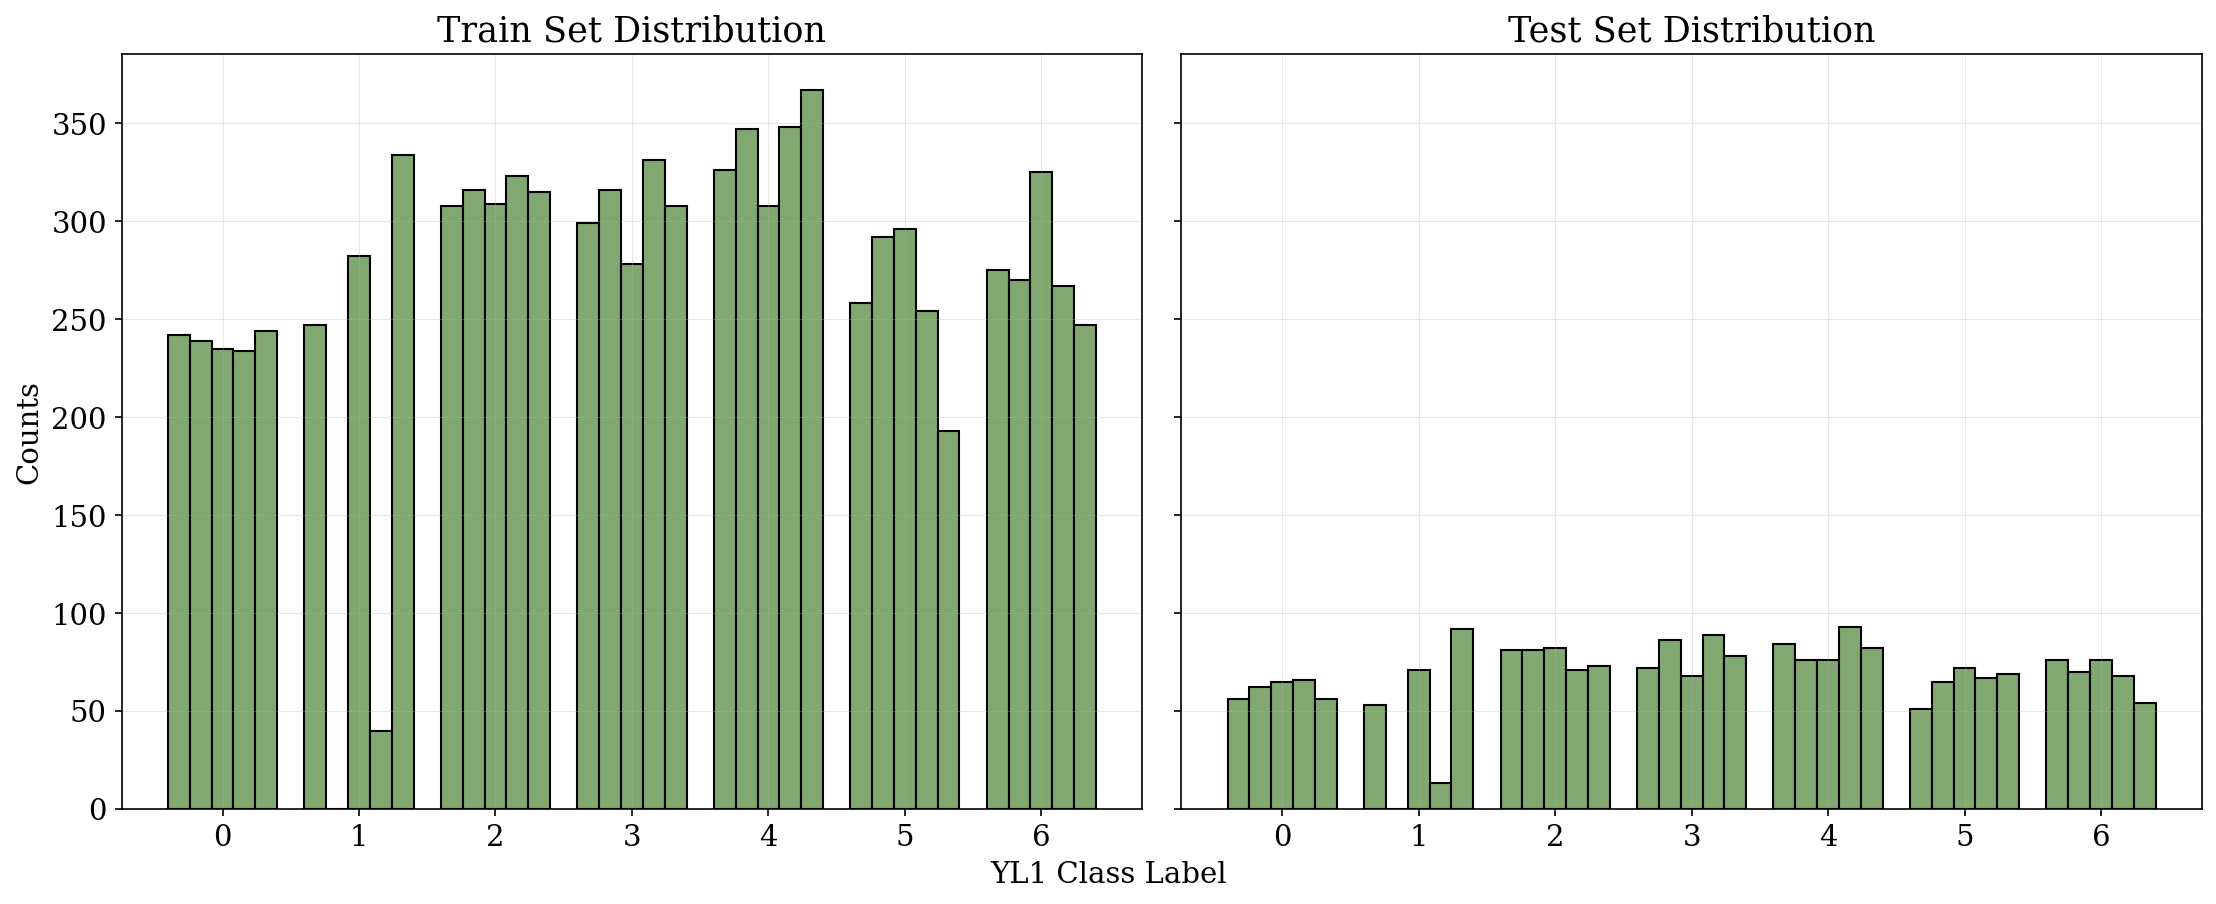

In [ ]:
# Get all possible labels -> ASSUMES THEY ARE CONSECUTIVE INTEGERS FROM 0 TO N-1
parent_labels = np.arange(len(np.unique(WOS11967_dataset.YL1)))
child_labels = np.arange(len(np.unique(WOS11967_dataset.YL2)))

# Plot stats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
plot_stats(train_stats, ax1, parent_labels=parent_labels, child_labels=child_labels)
plot_stats(test_stats, ax2, parent_labels=parent_labels, child_labels=child_labels)

# Labels
fig.text(0.5, 0, "YL1 Class Label", ha='center')
ax1.set_ylabel("Counts")

# Titles
ax1.set_title('Train Set Distribution')
ax2.set_title('Test Set Distribution')

plt.tight_layout()
plt.savefig(SAVEDIR + 'YL1_YL2_distribution.png')
plt.show()

In [ ]:
train_dataset.dataset[5]

(tensor([[ 0.7227,  0.3695,  0.1754,  ..., -0.1438,  0.4005,  0.3564],
         [ 0.0526,  0.3701, -0.2052,  ..., -0.6682,  0.1027,  0.2918],
         [ 0.3544, -1.2952,  3.7335,  ..., -0.0540, -3.2711,  1.6463],
         ...,
         [-3.5170,  2.2783,  1.8536,  ...,  0.6305, -2.2493, -0.3213],
         [ 0.5227, -0.5895, -0.2058,  ..., -1.2932, -0.4293, -0.7495],
         [ 0.1480,  1.2579, -1.6597,  ...,  1.0716,  0.7141, -0.9385]]),
 tensor(0))

# Implement LSTM class

- can use pytorch.nn.Module
- For the LSTM model, you must design the data pre-processing pipeline that turns the unstructured text data into
numerical features. You are free to choose your encoding method, including pre-trained methods like word2vec;
however, there should be some justification for your choice in your report.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cuda', nprocess=None):
        super().__init__()
        
        # device setup
        device = device.lower()
        assert device in ('cuda', 'cpu'), "Device must be 'cuda' or 'cpu'"
        use_cuda = (device == 'cuda') and torch.cuda.is_available()
        self.device = torch.device('cuda' if use_cuda else 'cpu')
        if not use_cuda:
            nprocess = multiprocessing.cpu_count() // 2 if nprocess is None else nprocess # defaults to half available cores
            msg = "CUDA not available, using CPU instead" if device == 'cuda' else "Using CPU"
            log.info(f"{msg} with nprocess={nprocess}")
            torch.set_num_threads(nprocess)
            
        self.to(self.device)
        self.nprocess = nprocess
        
        # based heavily on pytorch implementation (but changed notation)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # training records (to add...)
        self.training_time = []
        self.training_loss = []
        self.validation_loss = []
        
        
        # Input gate
        self.W_xi = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Forget gate
        self.W_xf = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Candidate state
        self.W_xc = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True) # hidden

        # Output gate
        self.W_xo = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size, bias=True)
        
        
    def forward(self, x, hidden=None): 
        """ 
        Args:
            x: (batch_size, seq_len, input_size)
            hidden: tuple of (h, c) each (batch_size, hidden_size)
        """
        batch_size, seq_len, _ = x.size()
        
        if hidden is None:
            h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
            cs_t = torch.zeros(batch_size, self.hidden_size, device=x.device) # cell state
        else:
            h_t, cs_t = hidden
            
        for t in range(seq_len):
            x_t = x[:, t, :]
        
            i_t = torch.sigmoid(self.W_xi(x_t) + self.W_hi(h_t))
            f_t = torch.sigmoid(self.W_xf(x_t) + self.W_hf(h_t))
            c_t = torch.tanh(self.W_xc(x_t) + self.W_hc(h_t))
            o_t = torch.sigmoid(self.W_xo(x_t) + self.W_ho(h_t))
        
            cs_t = f_t * cs_t + i_t * c_t # update cell state
            h_t = o_t * torch.tanh(cs_t) # update hidden state
             
        y = self.W_hy(h_t) # bias included in Linear layer
        return y, (h_t, cs_t)
    
    
    def fit(self, dataset, epochs=10, lr=1e-3, batch_size=32, shuffle=True, optimizer='Adam', val_train_split=0, store_records=False):
        """
        Can chose between optimizers: Adam, RMSprop, Adagrad
        """        
        log.info(" == LSTM Training Initialization ==")
        if val_train_split > 0:
            val_size = int(len(dataset) * val_train_split)
            train_size = len(dataset) - val_size
            train_set, val_set = random_split(dataset, [train_size, val_size])
            val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=LSTM.collate_fn)
            dataset = train_set  # for training loader
            log.info(f"Splitting dataset into {100*(1-val_train_split):.1f}% train and {100*val_train_split:.1f}% validation")
        else:
            val_loader = None
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=LSTM.collate_fn)
        log.info(f"Training on {len(train_loader.dataset)} samples in {len(train_loader)} batches of size {batch_size}")
        
        # getting optimizer
        if  optimizer == 'Adam':
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer == 'RMSprop':
            opt = torch.optim.RMSprop(self.parameters(), lr=lr)
        elif optimizer == 'Adagrad':
            opt = torch.optim.Adagrad(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        log.info(f"Using {optimizer} optimizer with learning rate {lr}")
        
        # defining loss function to be cross entropy
        loss_fn = nn.CrossEntropyLoss()

        # training loop!
        log.info(" == Training LSTM Model ==")
        for epoch in range(epochs):
            t = time.time()
            total_loss = 0
            for X, Y in train_loader:
                X, Y = X.to(self.device), Y.to(self.device)
                opt.zero_grad()
                logits, _ = self.forward(X)
                loss = loss_fn(logits, Y)
                loss.backward()
                opt.step()

                total_loss += loss.item()
                
            if val_loader is not None:
                val_loss = 0
                for val_X, val_Y in val_loader:
                    val_X, val_Y = val_X.to(self.device), val_Y.to(self.device)
                    val_logits, _ = self.forward(val_X)
                    v_loss = loss_fn(val_logits, val_Y)
                    val_loss += v_loss.item()
                avg_val_loss = val_loss / len(val_loader)
                    
            avg_loss = total_loss / len(train_loader)
            t_epoch = time.time() - t
            time_to_completion = t_epoch * (epochs - epoch - 1) / 60
            if store_records:
                self.training_time.append(t_epoch)
                self.training_loss.append(avg_loss)
                if val_loader is not None:
                    self.validation_loss.append(avg_val_loss)

            # if log.getEffectiveLevel() <= logging.INFO: # print only if log level is INFO. Doing this to avoid issues with logging output
            if val_loader is not None:
                log.info(f"Epoch {epoch+1}/{epochs}, Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f} -- Time: {t_epoch:.2f}s == ~{time_to_completion:.2f}min remaining {' '*10}") 
            else:
                log.info(f"Epoch {epoch+1}/{epochs}, Train Loss = {avg_loss:.4f} -- Time: {t_epoch:.2f}s == ~{time_to_completion:.2f}min remaining {' '*10}") 
    
    
    @torch.no_grad() # disable gradient calculation for inference
    def predict(self, X):
        X = X.to(self.device)
        logits, _ = self.forward(X)
        return torch.argmax(logits, dim=1).cpu()

    def evaluate_acc(self, Y, Yhat):
        return np.mean(Y == Yhat)
    
    def evaluate_test_set(self, test_subset, batch_size=32):
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=LSTM.collate_fn)
        y_true = []
        y_pred = []
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(self.device)
            Y_batch = Y_batch.to(self.device)
            Yhat_batch = self.predict(X_batch)
            y_true.extend(Y_batch.detach().cpu().numpy())
            y_pred.extend(Yhat_batch.detach().cpu().numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc = self.evaluate_acc(y_true, y_pred)
        return acc, y_true, y_pred
    
    def plot_training_loss(self):
        plt.plot(self.training_loss, label='Training Loss')
        if self.validation_loss is not None and len(self.validation_loss) > 0:
            plt.plot(self.validation_loss, label='Validation Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('Training Loss over Epochs')
        plt.show()
        
    @staticmethod
    def collate_fn(batch):
        sequences, labels = zip(*batch)
        padded = pad_sequence(sequences, batch_first=True)
        labels = torch.stack(labels)
        return padded, labels

In [71]:
lstm = LSTM(
    input_size=100,  # embedding size
    hidden_size=512,
    output_size=7,  # number of classes
    device='cuda',
    nprocess=4
    )#.to('cuda') # move to GPU, if available

# run on WOS11967 dataset
lstm.fit(
    train_dataset, # subset of WOS11967_dataset
    epochs=15,
    lr=0.01,
    batch_size=256,
    shuffle=True,
    optimizer='Adam',
    store_records=True
)

11:31:58 -  == LSTM Training Initialization ==
11:31:58 - Training on 9573 samples in 38 batches of size 256


11:31:58 - Using Adam optimizer with learning rate 0.01
11:31:58 -  == Training LSTM Model ==


RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

In [ ]:
batch_sizes = [64, 128, 256, 512, 1024]
lrs = [0.001, 0.005, 0.01, 0.05]
results = {}
for batch_size in batch_sizes:
    for lr in lrs:
        log.info(f"Training with batch size: {batch_size} and learning rate: {lr}")
        lstm = LSTM(
            input_size=100,  # embedding size
            hidden_size=512,
            output_size=7,  # number of classes
            device='cuda',
            nprocess=4
            ).to('cuda') # move to GPU, if available
    
        lstm.fit(
            train_dataset, # subset of WOS11967_dataset
            epochs=50,
            lr=lr,
            batch_size=batch_size,
            shuffle=True,
            optimizer='Adam',
            store_records=True
        )
        
        acc, y_true, y_pred = lstm.evaluate_test_set(test_dataset, batch_size=batch_size)
        log.info(f"Test Accuracy with batch size {batch_size} and learning rate {lr}: {acc:.4f}")
        results[(batch_size, lr)] = {lstm: acc}
    

23:45:28 - Training with batch size: 64 and learning rate: 0.001
23:45:28 -  == LSTM Training Initialization ==
23:45:28 - Training on 9573 samples in 150 batches of size 64
23:45:28 - Using Adam optimizer with learning rate 0.001
23:45:28 -  == Training LSTM Model ==
23:47:32 - Epoch 1/50, Train Loss = 1.6346 -- Time: 124.41s == ~101.60min remaining           
23:49:36 - Epoch 2/50, Train Loss = 1.6122 -- Time: 123.86s == ~99.09min remaining           
23:51:40 - Epoch 3/50, Train Loss = 1.6116 -- Time: 123.97s == ~97.11min remaining           
23:53:49 - Epoch 4/50, Train Loss = 1.6100 -- Time: 128.66s == ~98.64min remaining           
23:55:56 - Epoch 5/50, Train Loss = 1.6096 -- Time: 127.33s == ~95.50min remaining           
23:58:04 - Epoch 6/50, Train Loss = 1.6080 -- Time: 127.93s == ~93.81min remaining           
00:00:06 - Epoch 7/50, Train Loss = 1.6047 -- Time: 122.28s == ~87.63min remaining           
00:02:07 - Epoch 8/50, Train Loss = 1.6057 -- Time: 121.10s == ~84.77min

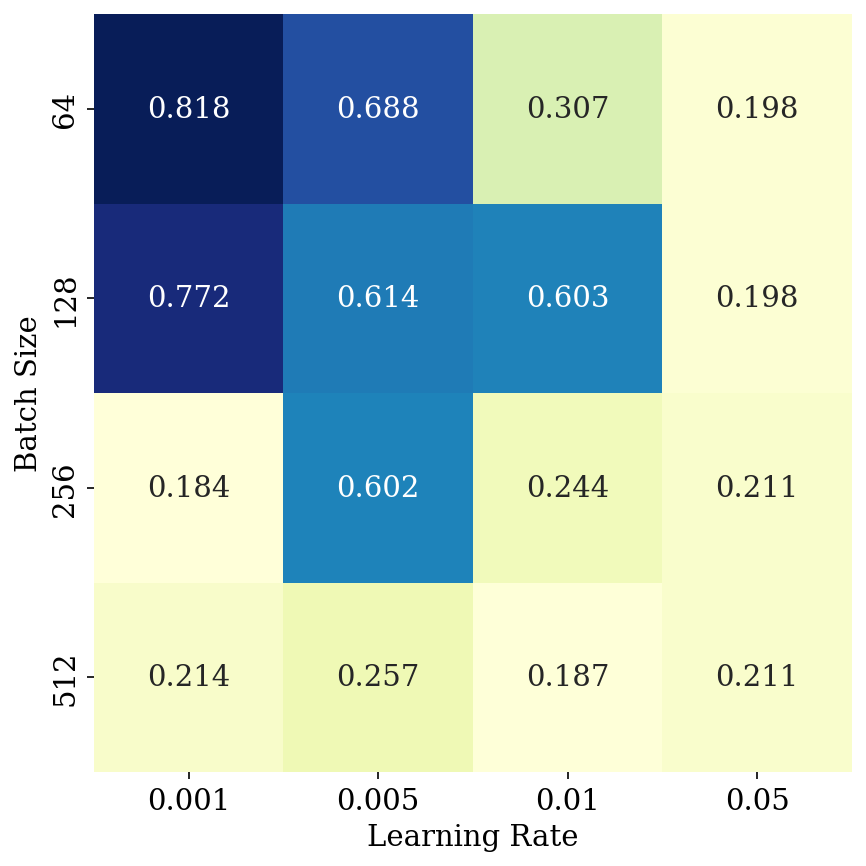

In [ ]:
# plot heatmap of batch size vs learning rate
ylabel = batch_sizes
xlabel = lrs
heatmap_acc = pd.DataFrame(index=ylabel[:-1], columns=xlabel)
for (batch_size, lr), acc in results.items():
    if batch_size == 1024:
        continue  # skip 1024 for better visualization
    batch_size = np.round(batch_size, 3)
    lr = np.round(lr, 3)
    heatmap_acc.at[batch_size, lr] = list(acc.values())[0] #acc[0]
sns.heatmap(heatmap_acc.astype(float), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, square=True)
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.grid(False)

# plt.title(f'Test Accuracy for MLP (L={L})')
# plt.savefig(os.path.join(SAVEDIR, f'gridsearch_mlp_L{L}_{xlabel}_{ylabel}.png'))
plt.show()

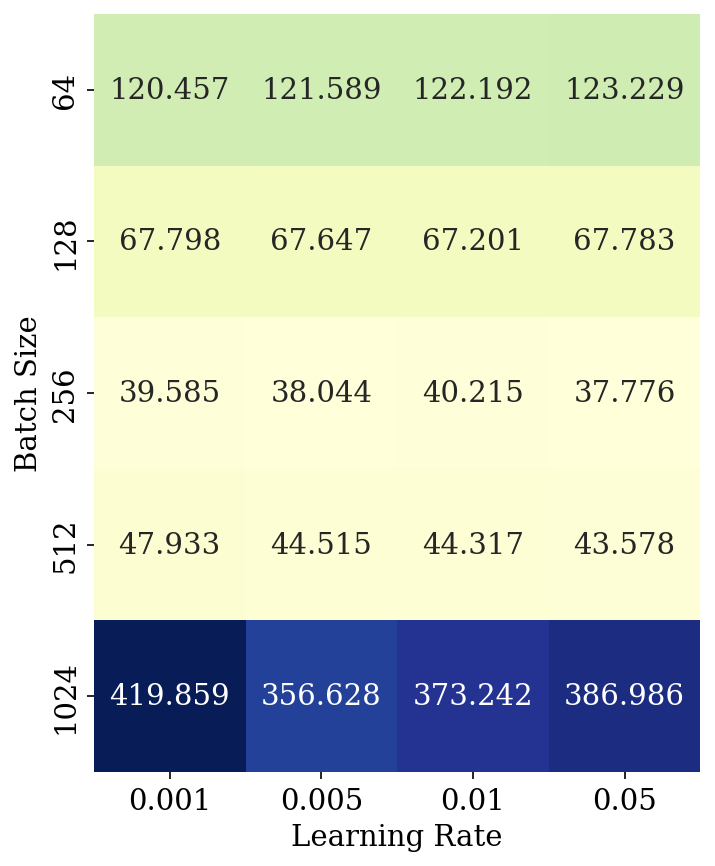

In [ ]:
# plot heatmap of batch size vs learning rate, but with time to train as values
ylabel = batch_sizes
xlabel = lrs
heatmap_acc = pd.DataFrame(index=ylabel, columns=xlabel)
for (batch_size, lr), acc in results.items():
    # if batch_size == 1024:
    #     continue  # skip 1024 for better visualization
    batch_size = np.round(batch_size, 3)
    lr = np.round(lr, 3)
    acc:dict
    heatmap_acc.at[batch_size, lr] = list(acc.keys())[0].training_time[-1] # last epoch time
sns.heatmap(heatmap_acc.astype(float), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, square=True)
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.grid(False)

# plt.title(f'Test Accuracy for MLP (L={L})')
# plt.savefig(os.path.join(SAVEDIR, f'gridsearch_mlp_L{L}_{xlabel}_{ylabel}.png'))
plt.show()

In [52]:
# save results
with open(os.path.join(MODELDIR, 'lstm_gridsearch_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

In [53]:
results_loaded = {}
with open(os.path.join(MODELDIR, 'lstm_gridsearch_results.pkl'), 'rb') as f:
    results_loaded = pickle.load(f)

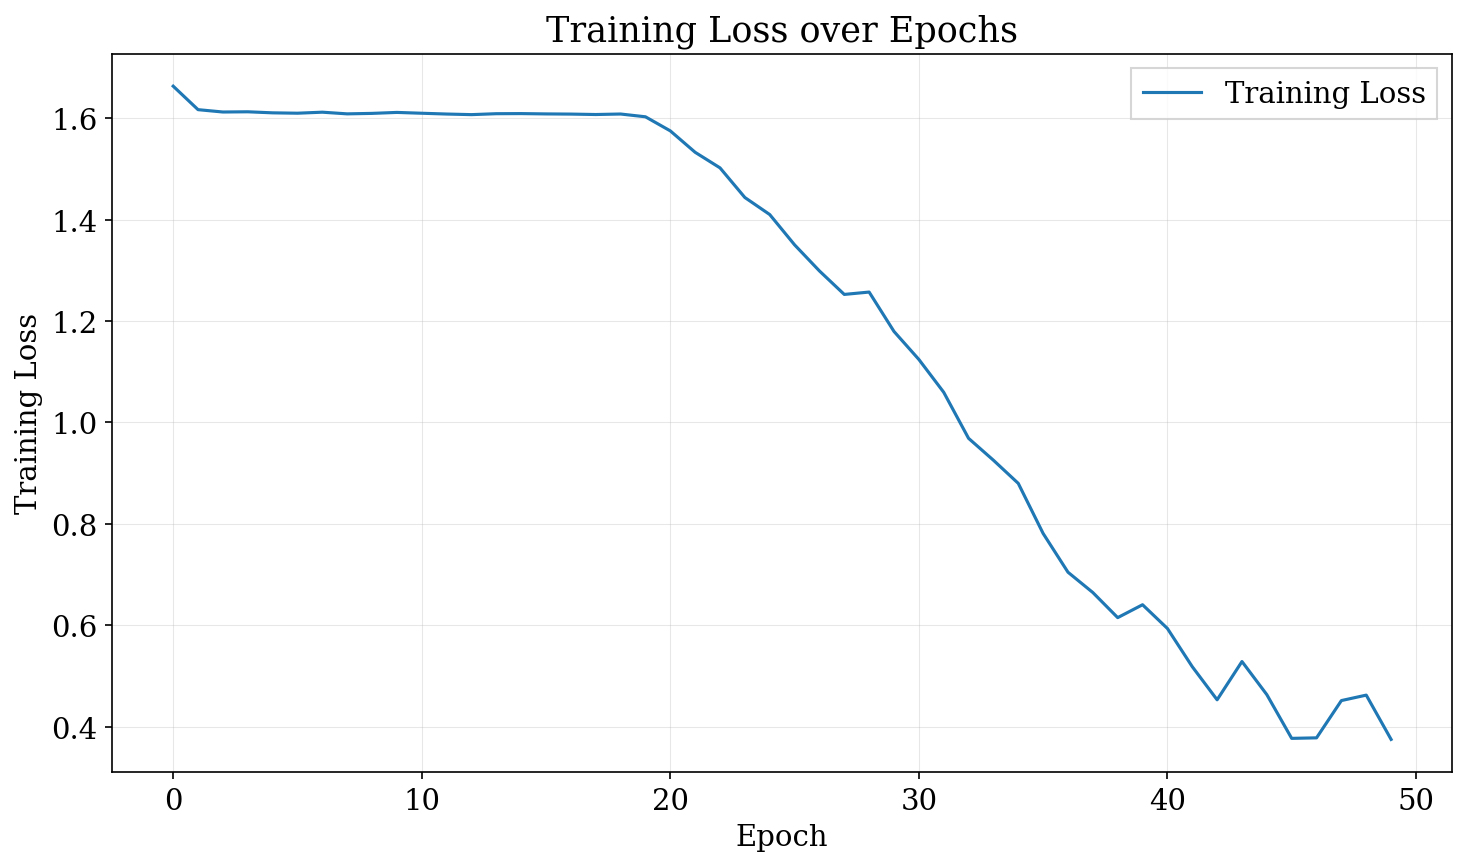

In [69]:
best_loaded = list(results_loaded[(256, 0.005)].keys())[0]

plt.plot(best_loaded.training_loss, label='Training Loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [62]:
best_loaded.validation_loss

[]

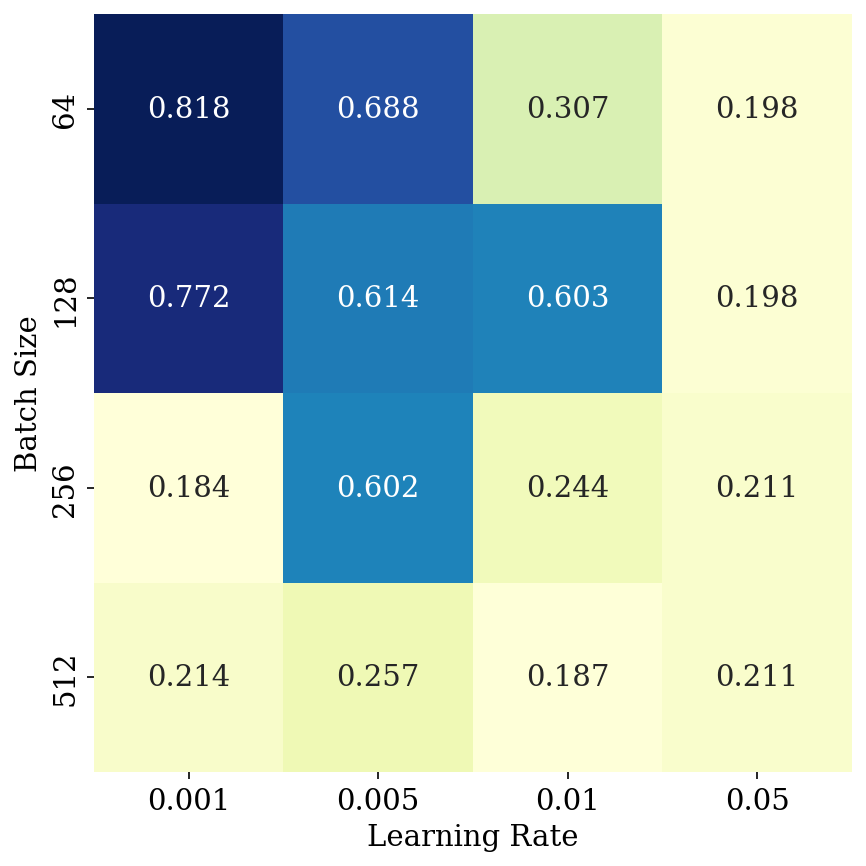

In [55]:
# plot heatmap of batch size vs learning rate
ylabel = batch_sizes
xlabel = lrs
heatmap_acc = pd.DataFrame(index=ylabel[:-1], columns=xlabel)
for (batch_size, lr), acc in results_loaded.items():
    if batch_size == 1024:
        continue  # skip 1024 for better visualization
    batch_size = np.round(batch_size, 3)
    lr = np.round(lr, 3)
    heatmap_acc.at[batch_size, lr] = list(acc.values())[0] #acc[0]
sns.heatmap(heatmap_acc.astype(float), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, square=True)
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.grid(False)

# plt.title(f'Test Accuracy for MLP (L={L})')
# plt.savefig(os.path.join(SAVEDIR, f'gridsearch_mlp_L{L}_{xlabel}_{ylabel}.png'))
plt.show()

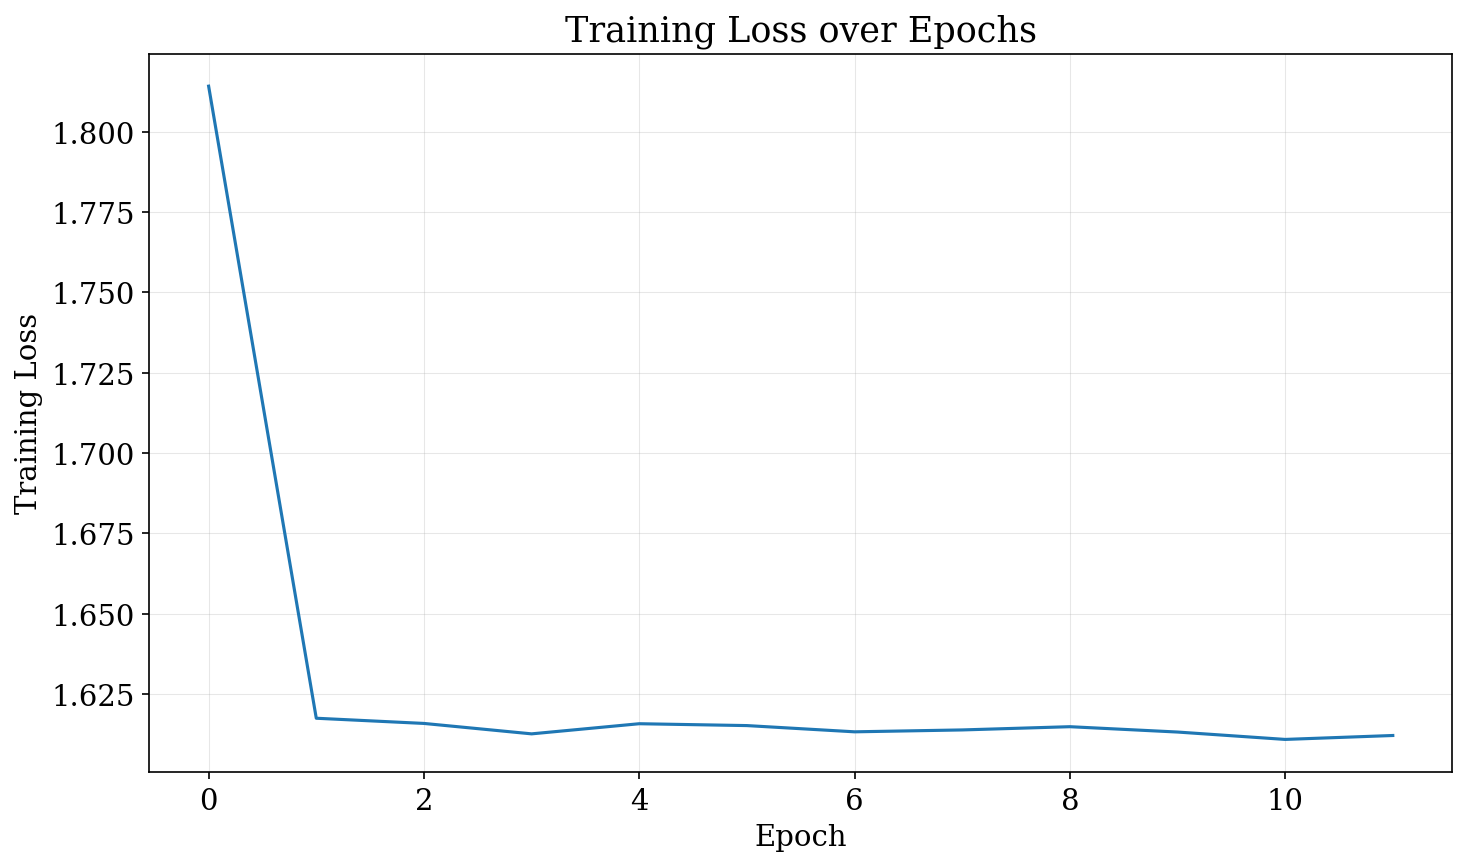

In [ ]:
lstm.plot_training_loss()

In [ ]:
lstm.evaluate_test_set(test_dataset)

(0.21261487050960734,
 array([0, 4, 0, ..., 4, 2, 3]),
 array([2, 2, 2, ..., 2, 2, 2]))

# BERT model

In [ ]:
# --- Load tokenizer & Model---
num_classes = 35  # flattened parent-child labels
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, clean_up_tokenization_spaces=True)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes
).to(device)
original_state_dict = model.state_dict()  # save original state dict for resetting later

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def bert_collate(batch):
    """
    Function to collate a batch of data for BERT model
    1. tokenize texts
    2. pad sequences to max length in batch
    3. return input_ids, attention_mask, labels
    """

    texts = [item[0] for item in batch]  # get texts
    labels = [item[4] for item in batch]  # use flattened labels

    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
        return_tensors="pt"
    )
    
    return enc["input_ids"], enc["attention_mask"], torch.tensor(labels)

In [ ]:
# Get tokenized loaders
train_loader_bert = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=bert_collate)
test_loader_bert = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=bert_collate)

In [ ]:
# --- Fine-Tuning BERT Model ---
# ** Running this on mimi GPU with a python script **
learning_rates = [1e-5, 2e-5, 3e-5]

# Dict to store all results
results = {}

for lr in learning_rates:
    # Reset optimizer & model
    optimizer = AdamW(model.parameters(), lr=lr)
    model.load_state_dict(original_state_dict)

    # Store losses and accuracies
    train_losses, test_losses, test_accuracies = [], [], []

    # Training loop (only a few epochs)
    num_epochs = 3
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        
        # Train
        model.train()
        total_loss = 0
        for batch in train_loader_bert:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader_bert)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader_bert:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                total_test_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_test_loss = total_test_loss / len(test_loader_bert)
            test_losses.append(avg_test_loss)
            test_acc = correct / total
            test_accuracies.append(test_acc)

            print(f"Epoch {epoch+1}/{num_epochs} -- "
                f"Train Loss: {avg_train_loss:.4f}, "
                f"Test Loss: {avg_test_loss:.4f}, "
                f"Test Acc: {test_acc:.4f}")
        
    # Store results for this learning rate
    results[lr] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "test_accuracy": test_accuracies
    }

    # Save model for this learning rate
    torch.save(model.state_dict(), MODELDIR + f"bert_model_lr{lr}.pth")

# Save final results
with open(MODELDIR + "bert_tuning_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
# Load tuning results

# Check optimal 


In [ ]:
# --- Training BERT Model ---
# ** Running this on mimi GPU with a python script **

# Optimizer

# Experiments

## some experiment etc